In [1]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional
import torch.optim
import torch.linalg as linalg
import matplotlib.pyplot as plt

In [2]:
from models import *
from plotting import *

In [3]:
random_seed = 1234
torch.manual_seed(random_seed)
n_epochs = 3
batch_size_train = 1000
batch_size_test = 1

In [4]:
# Loading MNIST data
import torchvision
import torchvision.transforms as transforms

mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.Lambda(lambda x : torch.flatten(x))])

trainset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=mnist_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=mnist_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=False)

In [7]:
def test_train(net, trainloader, testloader, name="", n_epochs=4, lr=0.0001):

    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optim = torch.optim.Adam(net.parameters(), lr=lr)

    train_losses = []
    train_counter = []
    test_losses = []
    test_accuracy = []

    def train(epoch):
        net.train()
        for batch_idx, (data, target) in enumerate(trainloader):

            optim.zero_grad()

            for i in range(batch_size_train):
                d=data[i,:].float()
                t=nn.functional.one_hot(target[i,:],num_classes=10).float()
                #optim.zero_grad()
                o = net(d)
                loss += loss_fn(o, t)

            loss.backward()
            optim.step()

            with torch.no_grad():
                    net.update_backwards()

            if batch_idx % 1000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(trainloader.dataset),
                    100. * batch_idx / len(trainloader), loss.item()))
                train_losses.append(loss.item())
                train_counter.append(
                    (batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))
    

    def test():
        net.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target_idx in testloader:
                data=torch.squeeze(data).float()
                target_idx = torch.squeeze(target_idx)
                target=nn.functional.one_hot(torch.squeeze(target_idx),num_classes=10).float()
                output = net(data)
                test_loss += loss_fn(output, target).item()
                pred_idx = torch.argmax(output.data)
                correct += pred_idx.eq(target_idx.data).sum()
            test_loss /= len(testloader.dataset)
            test_losses.append(test_loss)
            test_accuracy.append(100. * correct / len(testloader.dataset))
            print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                    test_loss, correct, len(testloader.dataset),
                    100. * correct / len(testloader.dataset)))
            
    torch.save(net.state_dict(), './results/model_{0}.pth'.format(name))
    torch.save(optim.state_dict(), './results/optimizer_{0}.pth'.format(name))
            
    test()
    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()
    
    return {"train_losses": train_losses, "train_counter": train_counter, "test_losses" : test_losses, "test_accuracy" : test_accuracy}

In [6]:
bp_net = FullyConnected(grad_type='backprop')
ps_net = FullyConnected(grad_type='pseudo')
rd_net = FullyConnected(grad_type='random')

In [8]:
bp_data = test_train(bp_net, trainloader, testloader, name="backprop")
torch.save(bp_data, './results/bp_data.pth')


Test set: Avg. loss: 6.9065, Accuracy: 1022/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 5.018192
Train Epoch: 1 [784000/60000 (2%)]	Loss: 4.332702
Train Epoch: 1 [1568000/60000 (3%)]	Loss: 2.781920
Train Epoch: 1 [2352000/60000 (5%)]	Loss: 3.241806
Train Epoch: 1 [3136000/60000 (7%)]	Loss: 1.785977
Train Epoch: 1 [3920000/60000 (8%)]	Loss: 0.106027
Train Epoch: 1 [4704000/60000 (10%)]	Loss: 1.186063
Train Epoch: 1 [5488000/60000 (12%)]	Loss: 0.691866
Train Epoch: 1 [6272000/60000 (13%)]	Loss: 0.216545
Train Epoch: 1 [7056000/60000 (15%)]	Loss: 5.117289
Train Epoch: 1 [7840000/60000 (17%)]	Loss: 0.407375
Train Epoch: 1 [8624000/60000 (18%)]	Loss: 1.078061
Train Epoch: 1 [9408000/60000 (20%)]	Loss: 0.909734
Train Epoch: 1 [10192000/60000 (22%)]	Loss: 1.990600
Train Epoch: 1 [10976000/60000 (23%)]	Loss: 0.686585
Train Epoch: 1 [11760000/60000 (25%)]	Loss: 0.393860
Train Epoch: 1 [12544000/60000 (27%)]	Loss: 0.052049
Train Epoch: 1 [13328000/60000 (28%)]	Loss: 2.924294
Train Epoch: 1

In [9]:
ps_data = test_train(ps_net, trainloader, testloader, name="pseudo")
torch.save(ps_data, './results/ps_data.pth')


Test set: Avg. loss: 7.3858, Accuracy: 817/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 8.544556
Train Epoch: 1 [784000/60000 (2%)]	Loss: 2.712574
Train Epoch: 1 [1568000/60000 (3%)]	Loss: 3.006912
Train Epoch: 1 [2352000/60000 (5%)]	Loss: 1.676460
Train Epoch: 1 [3136000/60000 (7%)]	Loss: 0.700361
Train Epoch: 1 [3920000/60000 (8%)]	Loss: 0.419280
Train Epoch: 1 [4704000/60000 (10%)]	Loss: 1.631757
Train Epoch: 1 [5488000/60000 (12%)]	Loss: 2.327405
Train Epoch: 1 [6272000/60000 (13%)]	Loss: 1.235378
Train Epoch: 1 [7056000/60000 (15%)]	Loss: 0.434543
Train Epoch: 1 [7840000/60000 (17%)]	Loss: 2.874666
Train Epoch: 1 [8624000/60000 (18%)]	Loss: 2.351513
Train Epoch: 1 [9408000/60000 (20%)]	Loss: 0.812112
Train Epoch: 1 [10192000/60000 (22%)]	Loss: 0.845325
Train Epoch: 1 [10976000/60000 (23%)]	Loss: 0.889339
Train Epoch: 1 [11760000/60000 (25%)]	Loss: 0.092462
Train Epoch: 1 [12544000/60000 (27%)]	Loss: 4.850276
Train Epoch: 1 [13328000/60000 (28%)]	Loss: 0.020471
Train Epoch: 1 [

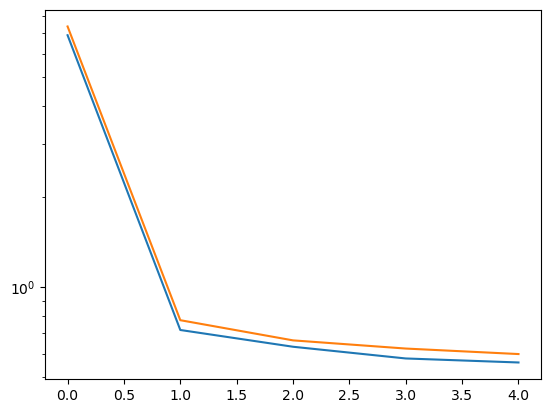

In [12]:
plt.plot(bp_data['test_losses'])
plt.plot(ps_data['test_losses'])
plt.yscale('log')
plt.show()

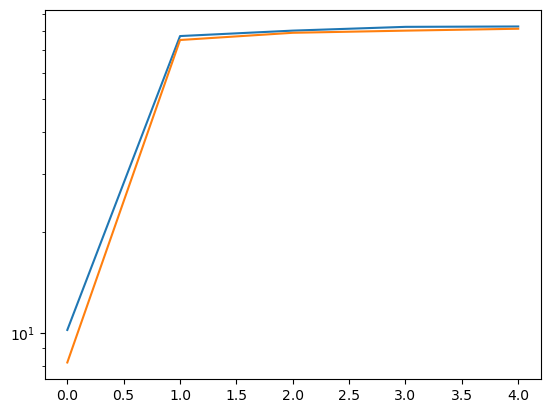

In [13]:
plt.plot(bp_data['test_accuracy'])
plt.plot(ps_data['test_accuracy'])
plt.yscale('log')
plt.show()

In [ ]:
input, target = testset[0]

output = net(input)

In [ ]:
softmax = nn.Softmax(dim=0)
out_softmax = softmax(output)

In [ ]:
out_softmax.round()

In [ ]:
plot_mnist(input)

In [ ]:
from plotting import *